<a href="https://colab.research.google.com/github/suhaodatascichem/Methionine-price/blob/main/Methionine_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import required libraries

In [1]:
# required libraries
import pandas as pd
import numpy as np
import datetime as dt

# for plots
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import MinMaxScaler
import math, time
from sklearn.metrics import mean_squared_error
import time
from sklearn.metrics import mean_squared_error

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Read Data

In [6]:
import pandas as pd

url = "https://raw.githubusercontent.com/suhaodatascichem/Methionine-price/f03e43d1167e30719338fa20fbd1b3a4fc844599/Indonesia%20daily%20import%20data%20-%20Copy%20for%20Su%20Hao%20(1).xlsx"
df_raw = pd.read_excel(url, engine="openpyxl")

In [7]:
df_raw.head(10)

,Date,Sum of CIF gross price(USD),Sum of Quantity in kg,Price
0,2023-01-02,558000.0,180000,3.100000
1,2023-01-03,561642.0,201820,2.782886
2,2023-01-04,132000.0,60000,2.200000
3,2023-01-05,45000.0,20000,2.250000
4,2023-01-09,92800.0,40000,2.320000
5,2023-01-10,46000.0,20000,2.300000
6,2023-01-11,125740.0,56000,2.245357
7,2023-01-13,225000.0,100000,2.250000
8,2023-01-16,186000.0,60000,3.100000
9,2023-01-17,545186.0,220060,2.477443


In [14]:
df_raw["Date"] = pd.to_datetime(df_raw["Date"])

In [15]:
startdate = df_raw['Date'].min()
print('startdate is ', startdate)
enddate = df_raw['Date'].max()
print("startdate is ", enddate)


startdate is  2023-01-02 00:00:00
startdate is  2025-01-31 00:00:00


In [16]:
df_raw.head(1)

,Date,Sum of CIF gross price(USD),Sum of Quantity in kg,Price
0,2023-01-02,558000.0,180000,3.1


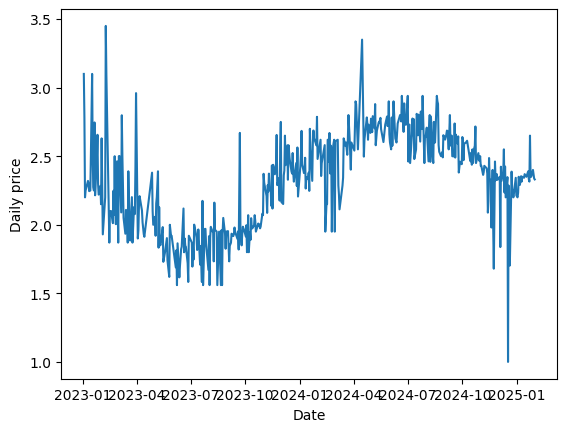

<Figure size 3200x200 with 0 Axes>

In [18]:
plt.plot(df_raw['Date'], df_raw["Price"])
plt.xlabel("Date")
plt.ylabel("Daily price")
plt.figure(figsize=(32,2))
plt.show()

In [20]:
df = df_raw

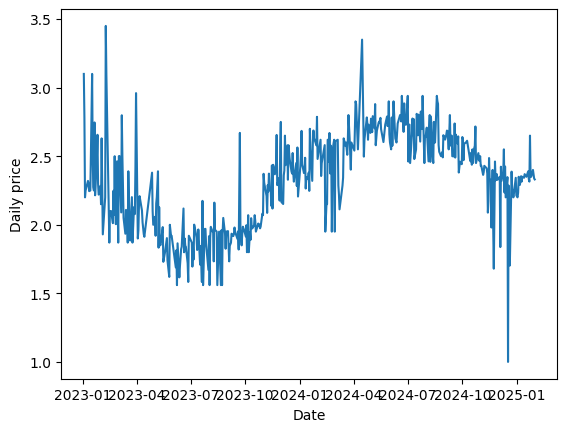

<Figure size 3200x200 with 0 Axes>

In [21]:
plt.plot(df['Date'], df["Price"])
plt.xlabel("Date")
plt.ylabel("Daily price")
plt.figure(figsize=(32,2))
plt.show()

In [22]:
# min-max nomalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df[['Price']] = scaler.fit_transform(df[['Price']])

## Data Prep

In [23]:
#Function to perform the train test split on the df based on the desired window_size (ws)
def train_test_prep(series, x_variables, y_variables,  window_size, test_size):
  # series should be a numpy series
  x_series = series[x_variables].to_numpy()
  y_series = series[y_variables].to_numpy()

  x_data = []
  y_data = []
  for i in range(len(x_series) - window_size):
    x_data.append(x_series[i: i+window_size])
    y_data.append(y_series[i+window_size])
  x_data = np.array(x_data)
  y_data = np.array(y_data)

  train_size = x_data.shape[0] - test_size

  train_x = x_data[:train_size, :,:]
  train_y = y_data[:train_size, :]

  test_x = x_data[train_size:train_size+test_size, :,:]
  test_y = y_data[train_size:train_size+test_size:, :]

  return [train_x, train_y, test_x, test_y]

In [24]:
ws = 30
test_size = 90

In [25]:
x_train, y_train, x_test, y_test = train_test_prep(df, ["Price"],["Price"], ws,test_size)

In [26]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((355, 30, 1), (90, 30, 1), (355, 1), (90, 1))

In [27]:
#Function to obtain train, test data as tensors for torch
def array_to_tensor(x_train, x_test, y_train, y_test):
  x_train_torch = torch.from_numpy(x_train).type(torch.Tensor).cuda()
  x_test_torch = torch.from_numpy(x_test).type(torch.Tensor).cuda()
  y_train_torch = torch.from_numpy(y_train).type(torch.Tensor).cuda()
  y_test_torch = torch.from_numpy(y_test).type(torch.Tensor).cuda()
  return x_train_torch, x_test_torch, y_train_torch, y_test_torch

In [28]:
x_train_torch, x_test_torch, y_train_torch, y_test_torch = array_to_tensor(x_train, x_test, y_train, y_test)

In [29]:
x_train_torch.shape, x_test_torch.shape, y_train_torch.shape, y_test_torch.shape

(torch.Size([355, 30, 1]),
 torch.Size([90, 30, 1]),
 torch.Size([355, 1]),
 torch.Size([90, 1]))

# Baseline model

In [30]:
# base line model that uses the previous time stamp's demand as the predicted demand

#function for baseline model
def baseline_rmse(df, ws, y_train_data, column_name):
  y_base_test = np.array(df[column_name][ws+y_train.shape[0]-1:-1],dtype=np.float32)
  y_base_label = np.array(df[column_name][ws+y_train.shape[0]:],dtype=np.float32)

  print(y_base_test, y_base_label)
  rmse_loss_test = np.sqrt(mean_squared_error(y_base_test, y_base_label))
  return rmse_loss_test

In [31]:
baseline_rmse(df, ws, y_train, 'Price')

[0.6116182  0.7096428  0.60816324 0.6765306  0.64981186 0.6712018
 0.5636735  0.59591836 0.5884694  0.66929686 0.6622449  0.60047096
 0.6489796  0.6530612  0.6582143  0.6018021  0.5967347  0.622449
 0.5869388  0.63265306 0.59183675 0.6357143  0.6432117  0.70068026
 0.59183675 0.62142855 0.6020408  0.5977573  0.6122449  0.5836735
 0.5836735  0.55663264 0.56483173 0.5836735  0.5762068  0.56093293
 0.44437468 0.47891158 0.6068027  0.5469388  0.5387755  0.4
 0.48270676 0.5714286  0.4        0.27755103 0.5964286  0.54064626
 0.55897427 0.54183674 0.547708   0.55110544 0.34183672 0.580968
 0.5387755  0.56600535 0.63265306 0.5043084  0.5816327  0.48979592
 0.55       0.         0.52478135 0.45034012 0.2868526  0.56632656
 0.5158853  0.48979592 0.5019493  0.5479592  0.4956916  0.48979592
 0.50340134 0.5510204  0.52690166 0.5526812  0.5367347  0.5510204
 0.5481633  0.5588697  0.5561606  0.5510204  0.56734693 0.5442177
 0.53674793 0.67346936 0.5510204  0.5510204  0.5714286  0.54592985] [0.709642

0.11442987414160107

# LSTM Model Architecture


In [32]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, num_epochs, dropout_rate):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [33]:
def build_lstm_model(input_dim, hidden_dim, num_layers, output_dim, num_epochs, dropout_rate):
  model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, num_epochs=num_epochs, dropout_rate=dropout_rate)
  model = model.cuda()
  cr = torch.nn.MSELoss(reduction='mean')
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  return model, cr, optimizer

In [34]:
input_dim = 1
output_dim = 1
dropout_rate = 0.3
# other Parameters
#num_layers = 2
#hidden_dim = 50
#num_epochs = 100


# Train LSTM Model

In [35]:
def train_model(model, cr, optimizer, x_train_torch, y_train_torch, x_test_torch, y_test_torch, num_epochs):
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)
  torch.cuda.manual_seed_all(42)
  np.random.seed(42)
  torch.backends.cudnn.deterministic = True

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)
  start_time = time.time()
  lstm = []


  for t in range(num_epochs):
    model.train()
    y_train_pred = model(x_train_torch)
    loss = cr(y_train_pred, y_train_torch)
    train_hist[t] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
      y_test_pred = model(x_test_torch)
      loss = cr(y_test_pred, y_test_torch)
      test_hist[t] = loss.item()
      #print("Epoch ", t, "train MSE: ", train_hist[t], "Test MSE:", test_hist[t])

  training_time = time.time()-start_time
  #print("Training time: {}".format(training_time))
  return y_train_pred, y_test_pred

# Get_RMSE



In [36]:
def get_RMSE(y_train_pred, y_train_torch , type='Train'):
  # invert predictions
  y_train_pred = y_train_pred.cpu().detach().numpy()
  y_train_final = y_train_torch.cpu().detach().numpy()

  # calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(y_train_final[:,0], y_train_pred[:,0]))
  print(f"{type} RMSE: ",trainScore)

  return trainScore

#Model parameters fine tuneing

In [37]:
# Function to vary the number of layers and hidden dimensions, and epochs to find the combination with the best RMSE
def model_tuning(x_train_torch, y_train_torch, x_test_torch, y_test_torch, input_dim, output_dim):
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)
  torch.cuda.manual_seed_all(42)
  np.random.seed(42)
  torch.backends.cudnn.deterministic = True
  testscore = 0
  nl = 0
  hd = 0
  epochs = 0
  summary = []
  for num_epochs in [100, 200, 300, 400]:
    for num_layers in [2, 3, 4, 5]:
      for hidden_dim in [25, 50, 75, 100]:
        model, cr, optimizer = build_lstm_model(input_dim, hidden_dim, num_layers, output_dim, num_epochs,dropout_rate)
        y_train_pred, y_test_pred = train_model(model, cr, optimizer, x_train_torch, y_train_torch, x_test_torch, y_test_torch, num_epochs)
        train_score = get_RMSE(y_train_torch, y_train_pred, type='Train')
        # test_score = get_test_rmse(x_test_torch, y_test_torch, model, ws, test_size)
        test_score = get_RMSE(y_test_torch, y_test_pred, type='Test')
        print(", Number of layers: ", num_layers, ", Hidden dimensions: ", hidden_dim, ", Number of Epochs:", num_epochs)
        summary.append({
            'Number of layers': num_layers,
            'Hidden dimensions': hidden_dim,
            'Number of Epochs': num_epochs,
            'Train RMSE': train_score,
            'Test RMSE': test_score
        })

        if test_score < testscore or testscore == 0 :
          testscore = test_score
          nl = num_layers
          hd = hidden_dim
          epochs = num_epochs
  print("Optimum Number of layers:", nl, "Optimum Hidden dimensions:", hd, "Optimum Number of Epochs:",epochs,"Test RMSE:", testscore)
  return nl, hd, epochs, summary

In [38]:
nl, hd, epochs, summary = model_tuning(x_train_torch, y_train_torch, x_test_torch, y_test_torch, input_dim, output_dim)

Train RMSE:  0.07495702105633462
Test RMSE:  0.08739683997018191
, Number of layers:  2 , Hidden dimensions:  25 , Number of Epochs: 100
Train RMSE:  0.07531059704449986
Test RMSE:  0.0892095729681098
, Number of layers:  2 , Hidden dimensions:  50 , Number of Epochs: 100
Train RMSE:  0.07703838164006709
Test RMSE:  0.0870392011018695
, Number of layers:  2 , Hidden dimensions:  75 , Number of Epochs: 100
Train RMSE:  0.07867582273853879
Test RMSE:  0.08820439597093453
, Number of layers:  2 , Hidden dimensions:  100 , Number of Epochs: 100
Train RMSE:  0.07614678801165534
Test RMSE:  0.08796940028321229
, Number of layers:  3 , Hidden dimensions:  25 , Number of Epochs: 100
Train RMSE:  0.07506600942118229
Test RMSE:  0.08677738404772105
, Number of layers:  3 , Hidden dimensions:  50 , Number of Epochs: 100
Train RMSE:  0.11205292137646235
Test RMSE:  0.09765942568383859
, Number of layers:  3 , Hidden dimensions:  75 , Number of Epochs: 100
Train RMSE:  0.08478790508982212
Test RMSE

In [39]:
summary_df = pd.DataFrame(summary)
summary_df

,Number of layers,Hidden dimensions,Number of Epochs,Train RMSE,Test RMSE
0,2,25,100,0.074957,0.087397
1,2,50,100,0.075311,0.089210
2,2,75,100,0.077038,0.087039
3,2,100,100,0.078676,0.088204
4,3,25,100,0.076147,0.087969
...,...,...,...,...,...
59,4,100,400,0.156303,0.108724
60,5,25,400,0.141706,0.096005
61,5,50,400,0.067455,0.089120
62,5,75,400,0.075455,0.096186


In [40]:
train_min_idx = summary_df['Train RMSE'].idxmin()
test_min_idx = summary_df['Test RMSE'].idxmin()

train_min_row = summary_df.loc[train_min_idx]
test_min_row = summary_df.loc[test_min_idx]

# Display the results
print("Row with the smallest Train Score: ", train_min_row)
#print(train_min_row)
print("\nRow with the smallest Test Score: ", test_min_row)

Row with the smallest Train Score:  Number of layers       5.000000
Hidden dimensions     50.000000
Number of Epochs     400.000000
Train RMSE             0.067455
Test RMSE              0.089120
Name: 61, dtype: float64

Row with the smallest Test Score:  Number of layers       4.000000
Hidden dimensions     75.000000
Number of Epochs     300.000000
Train RMSE             0.073296
Test RMSE              0.082429
Name: 42, dtype: float64


In [63]:
#from the above result, choose below parameters as the best
input_dim = 1
hidden_dim = 75
num_layers = 4
output_dim = 1
num_epochs = 300
dropout_rate = 0.3
model, cr, optimizer = build_lstm_model(input_dim, hidden_dim, num_layers, output_dim, num_epochs, dropout_rate)
y_train_pred, y_test_pred = train_model(model, cr, optimizer, x_train_torch, y_train_torch, x_test_torch, y_test_torch, num_epochs)


In [64]:
y_train.shape, y_train_pred.shape

((355, 1), torch.Size([355, 1]))

In [65]:
#reverse normalization
y_train = scaler.inverse_transform(y_train)
y_train_pred = scaler.inverse_transform(y_train_pred.cpu().detach().numpy())
y_test = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_test_pred.cpu().detach().numpy())

In [66]:
y_test_pred[1]

array([2.6076941], dtype=float32)

In [ ]:
#original_train = pd.DataFrame(y_train)
#predict_test = pd.DataFrame(y_test_pred)
#original_test = pd.DataFrame(y_test)


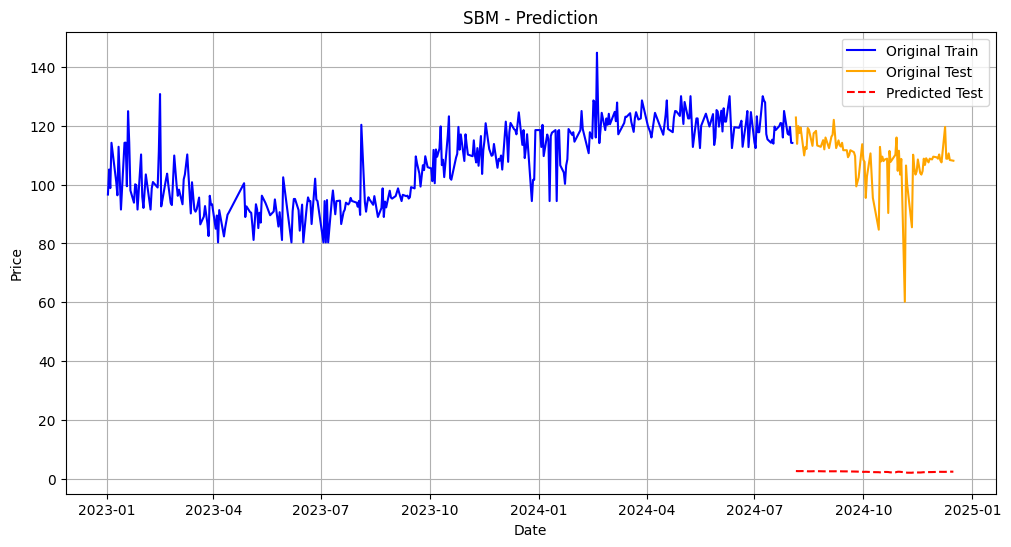

In [67]:
train_size = len(y_train)
test_size = len(y_test)
# Get the date ranges
train_dates = df['Date'][:train_size]
test_dates = df['Date'][train_size:train_size + test_size]

# Plot
plt.figure(figsize=(12, 6))
plt.style.use('default')
plt.plot(train_dates, y_train, label='Original Train', color = 'blue')
plt.plot(test_dates, y_test, label='Original Test', color = 'orange')
plt.plot(test_dates, y_test_pred, label='Predicted Test', linestyle='--', color = 'Red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('SBM - Prediction')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
r2_score = model.score(x_test_torch, y_test_torch)
print("R2 Score: ", r2_score)

AttributeError: 'LSTM' object has no attribute 'score'

#Get x days ahead worth of predictions

Scaled predictions: [[0.14645818]
 [0.1475824 ]
 [0.15313965]
 [0.15342236]
 [0.15181738]]


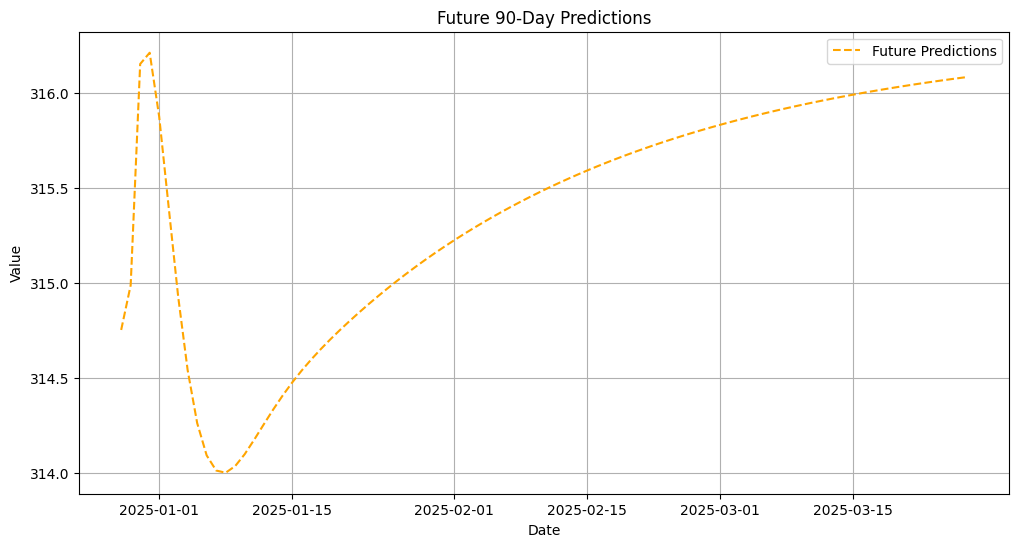

In [ ]:
def predict_future(model, initial_input, future_steps, scaler=None):
    """
    Predict future time steps using a trained LSTM model and inverse transform predictions if needed.

    :param model: Trained LSTM model
    :param initial_input: Torch tensor, last input sequence from the dataset
    :param future_steps: Number of future steps to predict
    :param scaler: Scaler used for normalization (e.g., MinMaxScaler). If None, assumes no scaling
    :return: Numpy array of future predictions in the original scale
    """
    model.eval()  # Set the model to evaluation mode
    predictions = []
    input_seq = initial_input.clone()  # Clone the input to avoid modifying the original

    with torch.no_grad():
        for step in range(future_steps):
            # Add batch dimension if needed
            if len(input_seq.shape) == 2:
                input_seq = input_seq.unsqueeze(0)  # Shape: (1, seq_len, input_dim)

            # Predict the next value
            pred = model(input_seq)  # Output shape: (1, output_dim) or (1, seq_len, output_dim)

            # Handle output dimensions dynamically
            if pred.dim() == 3:  # [batch_size, seq_len, output_dim]
                next_value = pred[:, -1, :]  # Get the last predicted value
            elif pred.dim() == 2:  # [batch_size, output_dim]
                next_value = pred  # Directly use the output

            # Add sequence dimension to next_value: [batch_size, 1, output_dim]
            next_value = next_value.unsqueeze(1)

            # Append to predictions
            predictions.append(next_value.squeeze().item())

            # Update input_seq by dropping the first time step and appending next_value
            input_seq = torch.cat((input_seq[:, 1:, :], next_value), dim=1)

    # Convert to numpy array
    predictions = np.array(predictions).reshape(-1, 1)  # Reshape for scaler

    # Debug: Check predictions before inverse transform
    print("Scaled predictions:", predictions[:5])
    #predictions = scaler.inverse_transform(predictions).flatten()
    # Inverse transform if a scaler was used
    #if scaler:
        #predictions = scaler.inverse_transform(predictions).flatten()  # Convert back to original scale

    # Debug: Check predictions after inverse transform
    #print("Inverse transformed predictions:", predictions[:5])

    return predictions




# Example usage
future_steps = 90
initial_input = x_test_torch[-1]  # Use the last input sequence from the test set
future_predictions = predict_future(model, initial_input, future_steps)
future_predictions = scaler.inverse_transform(future_predictions).flatten()
import pandas as pd
last_date = pd.to_datetime(df['Date'].iloc[-1])
future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, future_steps + 1)]

# Plot future predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions, label='Future Predictions', linestyle='--', color='orange')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Future 90-Day Predictions')
plt.legend()
plt.grid(True)
plt.show()

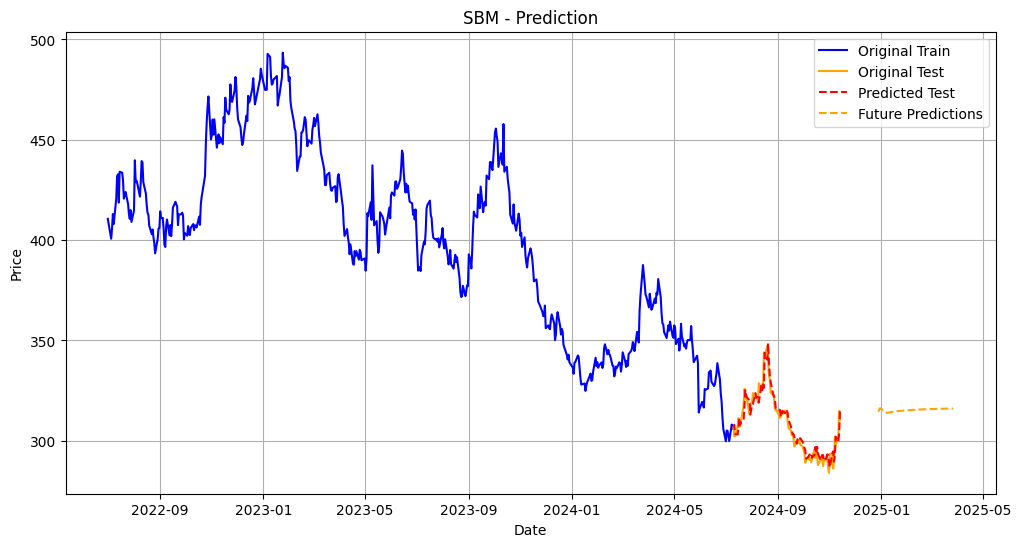

In [ ]:
plt.figure(figsize=(12, 6))
plt.style.use('default')
plt.plot(train_dates, y_train, label='Original Train', color = 'blue')
plt.plot(test_dates, y_test, label='Original Test', color = 'orange')
plt.plot(test_dates, y_test_pred, label='Predicted Test', linestyle='--', color = 'Red')
plt.plot(future_dates, future_predictions, label='Future Predictions', linestyle='--', color='orange')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('SBM - Prediction')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
  #Detach all torch tensors
  x_train_torch = x_train_torch.cpu().detach().numpy()
  x_test_torch = x_test_torch.cpu().detach()
  y_train_torch = y_train_torch.cpu().detach().numpy()
  y_test_torch = y_test_torch.cpu().detach().numpy()